In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
train_path = 'img3/train/'
valid_path = 'img3/validate/'
test_path = 'img3/test/'
    

In [4]:
# Data generators
train_datagen = ImageDataGenerator(
          rescale = 1./255,
          shear_range = 0.2,
          zoom_range = 0.2,
          horizontal_flip = True,
      fill_mode='nearest', #cval=125
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)



train_batches = train_datagen.flow_from_directory(
        # This is the target directory
        train_path,
        # All images will be resized to 150x150
        target_size=(262, 255),
        batch_size= 10,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_batches = test_datagen.flow_from_directory(
        valid_path,
        target_size=(262, 255),
        batch_size=6,
        class_mode='categorical')


test_batches = test_datagen.flow_from_directory(
        # This is the target directory
        test_path,
        # All images will be resized to 150x150
        target_size=(262, 255),
        batch_size=4,
        # Since we use categorical_crossentropy/binary loss, we need binary labels
        class_mode='categorical')


Found 189 images belonging to 3 classes.
Found 53 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [1]:
#plotImages(imgs)
#print(labels)

In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(262,255,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Flatten(),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()
model.save('try.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 262, 255, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 131, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 131, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 31, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 31, 128)       0         
__________

In [10]:
model.compile(optimizer=Adam(1e-5), loss='mean_squared_error', #metrics = ["accuracy"]
              metrics=[keras.metrics.BinaryAccuracy()]
             )

Instructions for updating:
Use tf.cast instead.


In [11]:
r = model.fit(train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    epochs= 100,
    verbose=2,
    shuffle=True, 
    #callbacks=[checkpoint,early]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[10,32,131,127] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


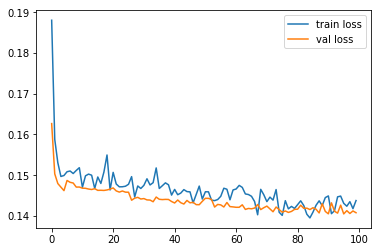

<Figure size 432x288 with 0 Axes>

In [41]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

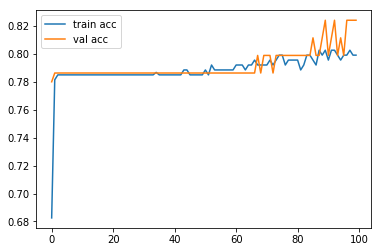

<Figure size 432x288 with 0 Axes>

In [42]:

# plot the accuracy
plt.plot(r.history['binary_accuracy'], label='train acc')
plt.plot(r.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [12]:
prediction = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('ce3-3904-C(Security-C)_9_6.png', target_size = (262,255,3))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)


In [22]:
result


array([[0.30203205, 0.3325773 , 0.36539072]], dtype=float32)

In [39]:
test_batches.class_indices

{'.ipynb_checkpoints': 0, 'bad': 1, 'good': 2}

In [126]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
predictions

array([[1.3048177e-04, 6.0105908e-01, 3.9881039e-01],
       [5.2571762e-04, 3.0196363e-01, 6.9751066e-01],
       [6.8147114e-04, 2.7180558e-01, 7.2751290e-01],
       [6.0133100e-04, 3.0802953e-01, 6.9136918e-01],
       [4.3183073e-04, 3.1195065e-01, 6.8761754e-01],
       [6.6711352e-04, 2.9199037e-01, 7.0734251e-01],
       [2.8434576e-04, 3.1446555e-01, 6.8525010e-01],
       [6.1824173e-04, 2.7812082e-01, 7.2126096e-01],
       [8.6142059e-04, 2.9689574e-01, 7.0224285e-01],
       [5.1420205e-04, 2.8499225e-01, 7.1449357e-01],
       [5.2756461e-04, 2.9111138e-01, 7.0836109e-01],
       [1.0625729e-03, 2.7227992e-01, 7.2665745e-01],
       [1.2035614e-03, 2.8783557e-01, 7.1096092e-01],
       [5.6013081e-04, 4.0063098e-01, 5.9880888e-01],
       [3.3830735e-04, 3.0833697e-01, 6.9132477e-01],
       [7.4181275e-04, 3.0097917e-01, 6.9827902e-01],
       [3.8397097e-04, 2.6237127e-01, 7.3724473e-01],
       [4.0516787e-04, 3.1655660e-01, 6.8303818e-01],
       [3.7482270e-04, 2.826

In [41]:
np.round(predictions)

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [42]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [43]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
test_batches.class_indices

{'.ipynb_checkpoints': 0, 'bad': 1, 'good': 2}

Confusion matrix, without normalization
[[ 0 10]
 [ 3 17]]


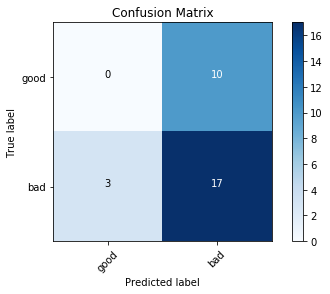

In [45]:
cm_plot_labels = ['good','bad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')